Oz Kilic  
COMP 5118 Project

# Model training and evaluation

Importing the libraries and the processed event dataset:

In [30]:
import numpy as np
import pandas as pd
import tqdm
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import math
import plotly.express as px
import plotly.graph_objs as go
import os
import wandb

position_tensors_folder = "position_tensors"
dataset_file = "dataset_processed.csv"

dataset = pd.read_csv(dataset_file)

print(dataset.columns)
dataset.describe()

Index(['match_id', 'id', 'pass_length', 'pass_height_ground',
       'pass_height_low', 'pass_height_high', 'pass_angle',
       'pass_angle_processed', 'angle_sin', 'angle_cos',
       'technique_inswinging', 'technique_outswinging', 'technique_straight',
       'technique_through_ball', 'technique_regular', 'type_corner',
       'type_free_kick', 'type_goal_kick', 'type_interception',
       'type_kick_off', 'type_recovery', 'type_throw_in', 'type_regular',
       'body_drop_kick', 'body_head', 'body_keeper_arm', 'body_left_foot',
       'body_other', 'body_right_foot', 'body_no_touch', 'outcome_incomplete',
       'outcome_injury', 'outcome_out', 'outcome_offside', 'outcome_unknown',
       'outcome_complete', 'miscommunication', 'cutback', 'shot_assist',
       'goal_assist', 'deflected', 'x', 'y', 'end_x', 'end_y'],
      dtype='object')


,match_id,pass_length,pass_height_ground,pass_height_low,pass_height_high,pass_angle,pass_angle_processed,angle_sin,angle_cos,technique_inswinging,technique_outswinging,technique_straight,technique_through_ball,technique_regular,type_corner,type_free_kick,type_goal_kick,type_interception,type_kick_off,type_recovery,type_throw_in,type_regular,body_drop_kick,body_head,body_keeper_arm,body_left_foot,body_other,body_right_foot,body_no_touch,outcome_incomplete,outcome_injury,outcome_out,outcome_offside,outcome_unknown,outcome_complete,miscommunication,cutback,shot_assist,goal_assist,deflected,x,y,end_x,end_y
count,8.539600e+04,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.00000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000,85396.000000
mean,3.815473e+06,20.231218,0.719155,0.107605,0.173240,0.008441,176.826774,0.006825,0.191324,0.003560,0.001967,0.000515,0.005738,0.988220,0.006523,0.013642,0.004508,0.011523,0.002857,0.081304,0.024556,0.855087,0.001312,0.036547,0.003958,0.284229,0.003513,0.624116,0.001206,0.161893,0.000691,0.017191,0.003209,0.004719,0.812298,0.000703,0.002424,0.01712,0.001874,0.001136,58.554905,39.967422,64.093960,39.861433
std,2.771165e+04,13.025171,0.449414,0.309882,0.378457,1.576559,114.916575,0.724874,0.661753,0.059559,0.044311,0.022693,0.075532,0.107897,0.080499,0.116002,0.066994,0.106725,0.053377,0.273302,0.154769,0.352015,0.036192,0.187649,0.062789,0.451049,0.059167,0.484353,0.034709,0.368355,0.026276,0.129981,0.056554,0.068534,0.390476,0.026498,0.049175,0.12972,0.043245,0.033684,26.898501,23.526658,27.619474,23.397743
min,3.788741e+06,0.000000,0.000000,0.000000,0.000000,-3.137833,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.100000,0.100000,0.100000,0.100000
25%,3.788765e+06,11.244554,0.000000,0.000000,0.000000,-1.238238,68.790800,-0.707107,-0.258819,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,39.100000,19.600000,43.800000,19.400000
50%,3.795220e+06,16.984405,1.000000,0.000000,0.000000,-0.013567,174.945500,0.000000,0.258819,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,57.600000,40.000000,63.900000,39.800000
75%,3.835341e+06,25.536250,1.000000,0.000000,0.000000,1.273290,284.645500,0.707107,0.866025,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,77.900000,60.300000,84.800000,60.300000
max,3.857271e+06,108.811770,1.000000,1.000000,1.000000,3.141593,360.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000

## Data filtering

Only regular pases are used. Also, passes that have the outcomes of "injury" and "unknown" or passes that resulted in the target player missing the pass due to miscommunication are removed. All unwanted features are removed except for match and event IDs (those are necessary to obtain the position tensors and removed by the dataset objects).

In [31]:
dataset_filtered = dataset[(dataset.technique_regular == 1) & (dataset.type_regular == 1) & (dataset.outcome_injury == 0) & (dataset.outcome_unknown == 0) & (dataset.miscommunication == 0)]

unwanted_columns = ["technique_*", "type_*", "pass_length", "pass_angle*", "outcome_incomplete", "outcome_injury", "outcome_out", "outcome_offside", "outcome_unknown", "miscommunication", "deflected", "goal_assist", "shot_assist", "end_*"]

for column in unwanted_columns:
    if "*" in column:
        column = column.split("*")[0]
        dataset_filtered = dataset_filtered.loc[:,~dataset_filtered.columns.str.startswith(column)]
    else:
        dataset_filtered.drop(columns=column, inplace=True)

dataset_filtered.reset_index(drop=True, inplace=True)
pd.options.display.max_columns = None
display(dataset_filtered.head(5))
display(dataset_filtered.describe())

,match_id,id,pass_height_ground,pass_height_low,pass_height_high,angle_sin,angle_cos,body_drop_kick,body_head,body_keeper_arm,body_left_foot,body_other,body_right_foot,body_no_touch,outcome_complete,cutback,x,y
0,3788741,84b9b798-0fbe-45bc-a4bf-3621959f29ce,0,0,1,-0.866025,0.500000,0,0,0,1,0,0,0,1,0,36.2,30.4
1,3788741,bfcfd5ad-1dda-44c9-9f3d-9b33b59983a6,1,0,0,-0.965926,0.258819,0,0,0,0,0,1,0,1,0,3.3,12.7
2,3788741,14604dfa-65b1-40c0-a11e-7c6b037806c0,1,0,0,-0.707107,0.707107,0,0,0,0,0,1,0,1,0,9.1,38.9
3,3788741,2b3361c2-de34-4eea-bcd8-1815de59a72d,1,0,0,1.000000,0.000000,0,0,0,0,0,1,0,1,0,28.8,49.9
4,3788741,e8da1a83-3012-43f1-9dc9-94dbf9de6e24,1,0,0,-0.965926,-0.258819,0,0,0,1,0,0,0,1,0,37.9,20.2


,match_id,pass_height_ground,pass_height_low,pass_height_high,angle_sin,angle_cos,body_drop_kick,body_head,body_keeper_arm,body_left_foot,body_other,body_right_foot,body_no_touch,outcome_complete,cutback,x,y
count,7.218600e+04,72186.000000,72186.000000,72186.000000,72186.000000,72186.000000,72186.000000,72186.000000,72186.000000,72186.000000,72186.000000,72186.000000,72186.000000,72186.000000,72186.000000,72186.000000,72186.000000
mean,3.814945e+06,0.791622,0.075139,0.133239,0.002929,0.167927,0.001482,0.013548,0.004682,0.300127,0.002494,0.665392,0.001413,0.838043,0.002798,58.745912,39.885900
std,2.773017e+04,0.406152,0.263618,0.339835,0.736946,0.654764,0.038472,0.115607,0.068268,0.458316,0.049874,0.471856,0.037564,0.368414,0.052826,26.363352,23.006263
min,3.788741e+06,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000
25%,3.788765e+06,1.000000,0.000000,0.000000,-0.707107,-0.258819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,40.000000,19.800000
50%,3.795187e+06,1.000000,0.000000,0.000000,0.000000,0.258819,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,57.800000,39.800000
75%,3.835340e+06,1.000000,0.000000,0.000000,0.707107,0.707107,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,77.900000,60.000000
max,3.857271e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,120.000000,80.000000


Here we check some descriptive statistics to see if complete and non-complete (incomplete or offside) differ:

In [32]:
display(dataset_filtered[dataset_filtered.outcome_complete == 0].describe())
dataset_filtered[dataset_filtered.outcome_complete == 1].describe()

,match_id,pass_height_ground,pass_height_low,pass_height_high,angle_sin,angle_cos,body_drop_kick,body_head,body_keeper_arm,body_left_foot,body_other,body_right_foot,body_no_touch,outcome_complete,cutback,x,y
count,1.169100e+04,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.000000,11691.0,11691.000000,11691.000000,11691.000000
mean,3.818127e+06,0.353434,0.192712,0.453853,0.029323,0.585166,0.006073,0.043709,0.000513,0.312292,0.003079,0.594047,0.001967,0.0,0.009922,63.399453,41.062475
std,2.722851e+04,0.478057,0.394446,0.497887,0.642550,0.493870,0.077696,0.204455,0.022649,0.463448,0.055408,0.491097,0.044313,0.0,0.099119,32.920516,24.774304
min,3.788741e+06,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.600000,0.100000
25%,3.788768e+06,0.000000,0.000000,0.000000,-0.500000,0.258819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,37.400000,18.300000
50%,3.835320e+06,0.000000,0.000000,0.000000,0.000000,0.866025,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,64.400000,42.100000
75%,3.835342e+06,1.000000,0.000000,1.000000,0.500000,0.965926,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,91.400000,64.400000
max,3.857271e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,120.000000,79.800000


,match_id,pass_height_ground,pass_height_low,pass_height_high,angle_sin,angle_cos,body_drop_kick,body_head,body_keeper_arm,body_left_foot,body_other,body_right_foot,body_no_touch,outcome_complete,cutback,x,y
count,6.049500e+04,60495.000000,60495.000000,60495.000000,60495.000000,60495.000000,60495.000000,60495.000000,60495.000000,60495.000000,60495.000000,60495.000000,60495.000000,60495.0,60495.000000,60495.000000,60495.000000
mean,3.814330e+06,0.876304,0.052418,0.071279,-0.002172,0.087293,0.000595,0.007720,0.005488,0.297777,0.002380,0.679180,0.001306,1.0,0.001422,57.846589,39.658521
std,2.778432e+04,0.329237,0.222869,0.257292,0.753725,0.651376,0.024387,0.087522,0.073878,0.457285,0.048731,0.466796,0.036114,0.0,0.037678,24.797663,22.641841
min,3.788741e+06,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.100000,0.100000
25%,3.788764e+06,1.000000,0.000000,0.000000,-0.866025,-0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,40.300000,20.100000
50%,3.795109e+06,1.000000,0.000000,0.000000,0.000000,0.258819,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.000000,57.200000,39.500000
75%,3.835339e+06,1.000000,0.000000,0.000000,0.707107,0.707107,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.0,0.000000,76.400000,59.200000
max,3.857271e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,120.000000,80.000000


In [173]:
# # dataset_filtered_combined = dataset_filtered.copy()
# # dataset_filtered_combined.insert(0, "positions", None)
# # dataset_filtered_combined["positions"] = None

# # dataset_filtered_combined.head(5)



# def add_positions(df):
#     df.reset_index(drop=True, inplace=True)
#     # position_tensors = np.zeros(shape=(df.shape[0], 4, 80, 120))
#     # combined = np.zeros(shape=(df.shape[0], df.shape[1]+1))
#     # combined = np.array((df.shape[0],df.shape[1]-1))
#     positions_tensors = [None] * df.shape[0]
#     # combined = [None] * df.shape[0]

#     for row_id, row in df.iterrows():
#         # print(row_id)
#         positions = np.load(f"{position_tensors_folder}/{row.match_id}/{row.id}.npy")
#         positions_tensors[row_id] = positions.tolist()
#         # dataset_filtered_combined.loc[row_id, "positions"] = positions
#         # combined[row_id,0] = positions
#         # row = row.drop(["match_id", "id"], axis=0).astype(float).to_list()
#         # print(row)
#         # temp = [positions.tolist()] + row
#         # print(len(temp[2]))
#         # temp.extend(row)
#         # print(temp)
#         # break
#         # combined = np.append(combined, temp)
#         # combined[row_id] = temp

#     # print(combined.shape)
#     # print(len(combined))
#     # print(combined)
#     # df.drop(columns=["match_id", "id"], inplace=True)
#     return (torch.tensor(positions_tensors), torch.from_numpy(df.drop(["match_id", "id"], axis=1).astype(float).to_numpy()))
    
# positions, features = add_positions(dataset_filtered.head(5))

# print(positions.shape)
# print(features.shape)
# print(features)
# print(torch.cat((positions.view(5, -1), features), axis=1).shape)

torch.Size([5, 4, 80, 120])
torch.Size([5, 22])
tensor([[57.0211,  0.0000,  0.0000,  1.0000, -0.8660,  0.5000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000, 36.2000, 30.4000, 70.7000, 75.8000],
        [23.9460,  1.0000,  0.0000,  0.0000, -0.9659,  0.2588,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  3.3000, 12.7000,  7.9000, 36.2000],
        [13.9054,  1.0000,  0.0000,  0.0000, -0.7071,  0.7071,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  9.1000, 38.9000, 19.7000, 47.9000],
        [26.7686,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000, 28.8000, 49.9000, 31.8000, 23.3000],
        [20.0898,  1.0000,  0.0000,  0.0000, -0.

Here we define the custom dataset class that combines the event with the position tensor. The dataset is distributed into training (70%), validation (15%), and testing (15%) datasets using stratified sampling (based on the outcome class).

In [33]:
class PassesDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, position_tensors_folder):
        self.dataset = dataset
        self.position_tensors_folder = position_tensors_folder
        # self.dataset.reset_index(drop=True, inplace=True)

    def __len__(self):
        return self.dataset.shape[0]
    
    def add_positions(self, df):
        df.reset_index(drop=True, inplace=True)
        positions_tensors = [None] * df.shape[0]

        for row_id, row in df.iterrows():
            positions = np.load(f"{self.position_tensors_folder}/{row.match_id}/{row.id}.npy")
            positions_tensors[row_id] = positions.tolist()
        
        labels = df.pop("outcome_complete").tolist()
        
        return torch.tensor(positions_tensors), torch.from_numpy(df.drop(["match_id", "id"], axis=1).astype(float).to_numpy()), torch.tensor(labels)

    def __getitem__(self, idx):
        positions, features, labels = self.add_positions(self.dataset.iloc[[idx]])
        return positions[0], features[0], labels[0]


seed = 42

# 0.7 train, 0.15 validation, 0.15 test
train_dataset, non_train_dataset = train_test_split(dataset_filtered, test_size=0.3, stratify=dataset_filtered.outcome_complete, shuffle=True, random_state=seed)
validation_dataset, test_dataset = train_test_split(non_train_dataset, test_size=0.5, stratify=non_train_dataset.outcome_complete, shuffle=True, random_state=seed)

print("Dataset shapes:",train_dataset.shape, validation_dataset.shape, test_dataset.shape)

Dataset shapes: (50530, 18) (10828, 18) (10828, 18)


Here we manually check if there are some major distribution differences between the datasets:

In [34]:
display(train_dataset.describe())
display(validation_dataset.describe())
display(test_dataset.describe())

,match_id,pass_height_ground,pass_height_low,pass_height_high,angle_sin,angle_cos,body_drop_kick,body_head,body_keeper_arm,body_left_foot,body_other,body_right_foot,body_no_touch,outcome_complete,cutback,x,y
count,5.053000e+04,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000
mean,3.814881e+06,0.792500,0.074669,0.132832,0.002571,0.168548,0.001583,0.013259,0.004730,0.298516,0.002513,0.666792,0.001385,0.838037,0.002810,58.727271,39.819080
std,2.767875e+04,0.405521,0.262858,0.339396,0.737142,0.654389,0.039759,0.114385,0.068612,0.457611,0.050071,0.471365,0.037194,0.368421,0.052937,26.416214,23.041724
min,3.788741e+06,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000
25%,3.788765e+06,1.000000,0.000000,0.000000,-0.707107,-0.258819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,39.900000,19.700000
50%,3.795187e+06,1.000000,0.000000,0.000000,0.000000,0.258819,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,57.700000,39.700000
75%,3.835340e+06,1.000000,0.000000,0.000000,0.707107,0.707107,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,77.900000,60.100000
max,3.857271e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,120.000000,80.000000


,match_id,pass_height_ground,pass_height_low,pass_height_high,angle_sin,angle_cos,body_drop_kick,body_head,body_keeper_arm,body_left_foot,body_other,body_right_foot,body_no_touch,outcome_complete,cutback,x,y
count,1.082800e+04,10828.00000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000
mean,3.814942e+06,0.78925,0.078685,0.132065,0.000976,0.158829,0.001478,0.014961,0.004433,0.305504,0.002494,0.658940,0.001662,0.838105,0.003602,58.879304,40.161018
std,2.782438e+04,0.40786,0.269259,0.338577,0.736820,0.657236,0.038414,0.121403,0.066436,0.460642,0.049875,0.474087,0.040740,0.368372,0.059909,26.297992,22.986663
min,3.788741e+06,0.00000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.100000
25%,3.788765e+06,1.00000,0.000000,0.000000,-0.707107,-0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,40.100000,20.000000
50%,3.795187e+06,1.00000,0.000000,0.000000,0.000000,0.258819,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,58.200000,40.500000
75%,3.835341e+06,1.00000,0.000000,0.000000,0.707107,0.707107,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,77.800000,59.900000
max,3.857271e+06,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,118.900000,79.800000


,match_id,pass_height_ground,pass_height_low,pass_height_high,angle_sin,angle_cos,body_drop_kick,body_head,body_keeper_arm,body_left_foot,body_other,body_right_foot,body_no_touch,outcome_complete,cutback,x,y
count,1.082800e+04,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000,10828.000000
mean,3.815248e+06,0.789897,0.073790,0.136313,0.006555,0.174125,0.001016,0.013484,0.004710,0.302272,0.002401,0.665312,0.001293,0.838013,0.001939,58.699511,39.922608
std,2.787575e+04,0.407401,0.261441,0.343137,0.736210,0.654004,0.031858,0.115339,0.068471,0.459264,0.048945,0.471903,0.035936,0.368456,0.043998,26.183092,22.859765
min,3.788741e+06,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.100000
25%,3.788765e+06,1.000000,0.000000,0.000000,-0.707107,-0.258819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,40.400000,20.100000
50%,3.795187e+06,1.000000,0.000000,0.000000,0.000000,0.258819,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,57.800000,39.700000
75%,3.835341e+06,1.000000,0.000000,0.000000,0.707107,0.707107,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,77.825000,59.800000
max,3.857271e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,120.000000,79.800000


## Model

This block defines the custom deep learning model:

In [35]:
class PassOutcomeModel(nn.Module):
    def __init__(self, hidden_layer_size=512, dropout_rate=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(3,3), stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout_rate)
 
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.flat = nn.Flatten()
 
        self.fc1 = nn.Linear(35279, hidden_layer_size)
        self.relu3 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_layer_size, 1)
    
    def forward(self, positions, features):
        # print("positions:", positions.shape, positions.is_cuda)
        # print("features:", features.shape, features.is_cuda)
        positions = self.conv1(positions)
        # print("After conv1:", positions.shape)
        positions = self.relu1(positions)
        positions = self.drop1(positions)
        
        positions = self.conv2(positions)
        # print("After conv2:", positions.shape)
        positions = self.relu2(positions)
        positions = self.pool1(positions)
        # print("After pool1:", positions.shape)
        
        positions_flat = self.flat(positions)
                                   
        combined = torch.cat((positions_flat.to(torch.float32), features.to(torch.float32)), dim=1)
        if positions.is_cuda:
            combined = combined.to("cuda")
        # print("combined:", combined.shape, combined.is_cuda)
        # print(combined)
        # print(self.fc1.weight.dtype)
        combined = self.fc1(combined)
        # print("After fc1:", combined.shape)
        combined = self.relu3(combined)
        combined = self.drop2(combined)
        combined = self.fc2(combined)
        # print("After fc2:", combined.shape)
        return combined.reshape(-1)
    
    
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.cuda.empty_cache() # running this instead of restarting a session can prevent some problems 

This block has some helper functions to train and evaluate the model:

In [36]:
def baseline_score(train_dataset, test_dataset): # naive classification score
    majority_class = train_dataset.outcome_complete.mode()[0]
    naive_prediction = [majority_class] * test_dataset.shape[0]
    return {"F1 score": f1_score(test_dataset.outcome_complete, naive_prediction, average="macro"), "Accuracy": accuracy_score(test_dataset.outcome_complete, naive_prediction)}   

def loss_fn(labels, predicted):
    return torch.sqrt(nn.MSELoss().to(device)(labels, predicted))

def binarize_predictions(predicted, decision_threshold):
    binary_predictions = (predicted > decision_threshold).astype(int)
    return binary_predictions

def evaluate(model, dataloader, device, decision_threshold=None):
    with torch.no_grad():
        model.eval()
        losses = []
        all_predictions = []
        all_labels = []
        for (positions, features, labels) in tqdm.tqdm(dataloader):
            # print(labels)
            (positions, features, labels) = (positions.to(device), features.to(device), labels.to(device).to(torch.float32))
            predicted = model(positions=positions, features=features)
            # print(predicted)
            # print(labels)
            all_predictions.extend(predicted.reshape(-1).cpu().detach().numpy())
            all_labels.extend(labels.reshape(-1).cpu().detach().numpy())
            loss = loss_fn(labels, predicted)
            losses.append(loss.item())
    
        if decision_threshold is None: # do not calculate the F1 score
            return {"RMSE": np.mean(np.asarray(losses))}
        else: # calculate the F1 score
            binary_labels = np.array(all_labels, dtype=int)
            if decision_threshold == "auto": # find the optimal decision threshold
                best_threshold = None
                best_threshold_score = -math.inf
                for threshold in np.arange(0.1, 0.9, 0.01):
                    binary_predictions = binarize_predictions(all_predictions, threshold)
                    f1 = f1_score(binary_labels, binary_predictions, average="macro")
                    if f1 > best_threshold_score:
                        best_threshold = threshold
                        best_threshold_score = f1
                    # break

                accuracy = accuracy_score(binary_labels, binary_predictions)

                return {"RMSE": np.mean(np.asarray(losses)), "F1 score": best_threshold_score, "Accuracy": accuracy, "Decision threshold": best_threshold}
            else: # calculate using the given threshold
                binary_predictions = (all_predictions > decision_threshold).astype(int)
                f1 = f1_score(binary_labels, binary_predictions, average="macro")
                accuracy = accuracy_score(binary_labels, binary_predictions)
                return {"RMSE": np.mean(np.asarray(losses)), "F1 score": f1, "Accuracy": accuracy, "Decision threshold": decision_threshold}
    

def train(model, optimizer, train_dataloader, validation_dataloader, device, epochs, save_model=False, model_name=None, save_graph=False, graph_name=None):
    model.train()
    train_losses = []
    validation_losses = []
    best_validation_f1 = -math.inf
    
    for epoch in range(1, epochs+1):
        print(f"=== EPOCH {epoch}")
        epoch_losses = []
        for (positions, features, labels) in tqdm.tqdm(train_dataloader):
            # print("labels:", labels.shape)
            (positions, features, labels) = (positions.to(device), features.to(device), labels.to(device).to(torch.float32))
            predicted = model(positions=positions, features=features)
            # print(predicted)
            # print(labels)
            loss = loss_fn(labels, predicted)
            epoch_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_losses.append(np.mean(np.asarray(epoch_losses)))
        evaluation_result = evaluate(model, validation_dataloader, device, decision_threshold="auto")
        
        if save_model and evaluation_result["F1 score"] > best_validation_f1: # new best model
            print(f"Saving the model at {model_name}...")
            torch.save(model, model_name)
            best_validation_f1 = evaluation_result["F1 score"]
        
        # print(evaluation_result)
        validation_losses.append(evaluation_result["RMSE"])
    
        print("Train RMSE:", train_losses[-1])
        print("Validation results:", evaluation_result)
        
        fig = go.Figure([
            go.Scatter(
                name="Training RMSE",
                x=list(range(1, len(train_losses)+1)),
                y=train_losses,
                # mode="lines",
                showlegend=True
            ),
            go.Scatter(
                name="Validation RMSE",
                x=list(range(1, len(validation_losses)+1)),
                y=validation_losses,
                # mode="lines",
                showlegend=True
            )
        ])

        fig.update_layout(
            yaxis_title="Error",
            xaxis_title="Epoch",
            xaxis = dict(
                tickmode = "array",
                tickvals = list(range(1,len(train_losses)+1)),
            ),
            # title="Happiness evolution",
            # title_x=0.5,
            hovermode="x"
        )
        if save_graph:
            fig.write_image(graph_name, scale=2)
        fig.show()
        
    model.eval()

### Hyperparameter optimization

We can optimize certain parameters using Weights and Biases. For efficiency purposes, I used a smaller portion of the actual dataset. I optimized the hidden layer size, dropout rate, learning rate, and batch size. This optimization could be more comprehensive in terms of ranges and parameters.

In [203]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\oz/.netrc


True

In [ ]:
sweep_config = {
    "method": "bayes", 
    "metric": {"name": "Validation RMSE", "goal": "minimize"},
    "parameters": {
        "hidden_layer_size": {"values": [128, 256, 512]},
        "dropout_rate": {"values": [0.1, 0.2, 0.3]},
        "learning_rate": {"distribution": "uniform", "min": 0.0005, "max": 0.002},
        # "learning_rate": {"values": [0.0005, 0.001, 0.0015]},
        "batch_size": {"values": [4, 8, 16]},
    },
    "early_terminate": {"type": "hyperband", "min_iter": 3}
}

sweep_id = wandb.sweep(sweep_config, project="comp5118_project_1")

# 30% of the actual dataset is used for optimization
optimization_dataset, _ = train_test_split(train_dataset, test_size=0.7, stratify=train_dataset.outcome_complete, shuffle=True, random_state=seed)

def experiment():
    config_defaults = {
        "hidden_layer_size": 512,
        "dropout_rate": 0.3,
        "learning_rate": 0.001,
        "batch_size": 4
    }
    wandb.init(config=config_defaults)
    
    config = wandb.config

    model = PassOutcomeModel(hidden_layer_size=config.hidden_layer_size, dropout_rate=config.dropout_rate)
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    
    batch_size = config.batch_size

    train_dataloader = torch.utils.data.DataLoader(PassesDataset(dataset=optimization_dataset, position_tensors_folder=position_tensors_folder), batch_size=batch_size, shuffle=True)
    validation_dataloader = torch.utils.data.DataLoader(PassesDataset(dataset=validation_dataset, position_tensors_folder=position_tensors_folder), batch_size=batch_size, shuffle=True)
    # test_dataloader = torch.utils.data.DataLoader(PassesDataset(dataset=test_dataset, position_tensors_folder=position_tensors_folder), batch_size=batch_size, shuffle=True)
    
    epochs = 3
    for epoch in range(1, epochs+1):
        print(f"=== EPOCH {epoch}")
        epoch_losses = []
        for (positions, features, labels) in tqdm.tqdm(train_dataloader):
            # print("labels:", labels.shape)
            (positions, features, labels) = (positions.to(device), features.to(device), labels.to(device).to(torch.float32))
            predicted = model(positions=positions, features=features)
            # print(predicted)
            # print(labels)
            loss = loss_fn(labels, predicted)
            epoch_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        epoch_loss = np.mean(np.asarray(epoch_losses))
        evaluation_result = evaluate(model, validation_dataloader, device, decision_threshold="auto")
    
        wandb.log({"Training RMSE": epoch_loss, "Validation RMSE": evaluation_result["RMSE"], "Validation F1": evaluation_result["F1 score"]})

wandb.agent(sweep_id, experiment)

500 response executing GraphQL.
{"errors":[{"message":"An internal error occurred. Please contact support.","path":["upsertSweep"]}],"data":{"upsertSweep":null}}
wandb: ERROR Error while calling W&B API: An internal error occurred. Please contact support. (<Response [500]>)


Create sweep with ID: cd5ckv4c
Sweep URL: https://wandb.ai/ozgunozankilic/comp5118_project_1/sweeps/cd5ckv4c


wandb: Agent Starting Run: 5g0rym35 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0006694794970092683


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:29<00:00,  4.52it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:47<00:00,  6.28it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:27<00:00,  7.73it/s]


Training RMSE,█▃▁
Validation F1,▁▇█
Validation RMSE,█▁▂
Training RMSE,0.29541
Validation F1,0.75345
Validation RMSE,0.30947


wandb: Agent Starting Run: 7unsdqoj with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0018414628200181008


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:55<00:00, 23.51it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:06<00:00, 21.48it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:26<00:00, 18.54it/s]


Training RMSE,█▂▁
Validation F1,▁█▃
Validation RMSE,▅▁█
Training RMSE,0.27238
Validation F1,0.74379
Validation RMSE,0.27516


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 12h5zsz4 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0018740216190419152


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:53<00:00,  5.94it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:39<00:00,  6.83it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:24<00:00,  8.05it/s]


Training RMSE,█▁▁
Validation F1,▁▆█
Validation RMSE,█▁▁
Training RMSE,0.30132
Validation F1,0.75152
Validation RMSE,0.29984


wandb: Agent Starting Run: d427bj7e with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0018672225930310496


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:27<00:00,  9.17it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:02<00:00, 11.04it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:36<00:00, 13.98it/s]


Training RMSE,█▂▁
Validation F1,▁▇█
Validation RMSE,█▄▁
Training RMSE,0.29667
Validation F1,0.75177
Validation RMSE,0.2857


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1xudszvy with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0009532506238481504


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:51<00:00,  6.07it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:47<00:00,  6.31it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:33<00:00,  7.28it/s]


Training RMSE,█▂▁
Validation F1,▁██
Validation RMSE,█▁▁
Training RMSE,0.30191
Validation F1,0.75292
Validation RMSE,0.3073


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w3bd5g06 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0017473825374995607


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:17<00:00, 19.69it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:39<00:00, 27.10it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:39<00:00, 27.15it/s]


Training RMSE,█▂▁
Validation F1,▃▁█
Validation RMSE,█▁▃
Training RMSE,0.27106
Validation F1,0.75137
Validation RMSE,0.27573


wandb: Agent Starting Run: a0qr1g4a with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0019153510027989551


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:53<00:00, 23.76it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:22<00:00, 19.02it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [03:11<00:00, 14.13it/s]


Training RMSE,█▂▁
Validation F1,▁▃█
Validation RMSE,█▂▁
Training RMSE,0.27146
Validation F1,0.75033
Validation RMSE,0.26266


wandb: Agent Starting Run: ca1hivh1 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.001977809385709944


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [03:01<00:00, 14.89it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [03:03<00:00, 14.74it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:44<00:00, 16.47it/s]


Training RMSE,█▂▁
Validation F1,▁▇█
Validation RMSE,█▂▁
Training RMSE,0.26641
Validation F1,0.74998
Validation RMSE,0.26278


wandb: Agent Starting Run: hm0kedjj with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0019417827807650192


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:30<00:00, 18.05it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:29<00:00, 18.09it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:30<00:00, 17.98it/s]


Training RMSE,█▂▁
Validation F1,▁█▇
Validation RMSE,██▁
Training RMSE,0.26843
Validation F1,0.74615
Validation RMSE,0.26168


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jdr1dbxz with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0019028609623830176


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:32<00:00, 17.79it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:32<00:00, 17.79it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:33<00:00, 17.66it/s]


Training RMSE,█▂▁
Validation F1,▃█▁
Validation RMSE,▂█▁
Training RMSE,0.26813
Validation F1,0.73734
Validation RMSE,0.26458


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4yrukuvm with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0019878017984814003


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:33<00:00, 17.64it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:34<00:00, 17.52it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:35<00:00, 17.43it/s]


Training RMSE,█▂▁
Validation F1,▃▁█
Validation RMSE,▅█▁
Training RMSE,0.27043
Validation F1,0.74989
Validation RMSE,0.25761


wandb: Agent Starting Run: 63emmr1x with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.000645204920348129


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [03:45<00:00,  3.00it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:19<00:00,  4.86it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:19<00:00,  4.86it/s]


Training RMSE,█▁▁
Validation F1,▁█▆
Validation RMSE,█▁▁
Training RMSE,0.30354
Validation F1,0.75495
Validation RMSE,0.30093


wandb: Agent Starting Run: zk0nu793 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0015474998380733554


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:16<00:00,  4.97it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:16<00:00,  4.95it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:16<00:00,  4.94it/s]


Training RMSE,█▂▁
Validation F1,▁█▆
Validation RMSE,█▁▂
Training RMSE,0.29997
Validation F1,0.7521
Validation RMSE,0.30536


wandb: Agent Starting Run: dsd2wp93 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0013172932724836205


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:39<00:00, 16.94it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:40<00:00, 16.90it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [03:00<00:00, 15.00it/s]


Training RMSE,█▂▁
Validation F1,▄▁█
Validation RMSE,█▁▄
Training RMSE,0.2648
Validation F1,0.75157
Validation RMSE,0.26528


wandb: Agent Starting Run: kx16ue5z with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.001231449828775683


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [03:42<00:00, 12.18it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:41<00:00, 16.73it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:42<00:00, 16.61it/s]


Training RMSE,█▂▁
Validation F1,▁▆█
Validation RMSE,▇█▁
Training RMSE,0.26771
Validation F1,0.74901
Validation RMSE,0.26785


wandb: Agent Starting Run: vn8gzkw4 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0008812556717659639


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:19<00:00,  4.84it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:19<00:00,  4.84it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:19<00:00,  4.85it/s]


Training RMSE,█▂▁
Validation F1,▁█▆
Validation RMSE,█▂▁
Training RMSE,0.29978
Validation F1,0.75259
Validation RMSE,0.29964


wandb: Agent Starting Run: j4jcn1tu with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0008416807780302509


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:19<00:00,  4.87it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:19<00:00,  4.86it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:18<00:00,  4.88it/s]


Training RMSE,█▂▁
Validation F1,▃█▁
Validation RMSE,▆▁█
Training RMSE,0.29972
Validation F1,0.75068
Validation RMSE,0.30577


wandb: Agent Starting Run: htxt4dmj with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.00165297767457321


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:21<00:00,  4.80it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:21<00:00,  4.79it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:22<00:00,  4.76it/s]


Training RMSE,█▂▁
Validation F1,█▁█
Validation RMSE,█▁▁
Training RMSE,0.29989
Validation F1,0.75466
Validation RMSE,0.30264


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: we7nht9p with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0013543597814701198


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:20<00:00,  4.83it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:20<00:00,  4.83it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:20<00:00,  4.82it/s]


Training RMSE,█▂▁
Validation F1,▁▁█
Validation RMSE,█▂▁
Training RMSE,0.30031
Validation F1,0.75393
Validation RMSE,0.30368


wandb: Agent Starting Run: zxqm61je with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0006085354617347945


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:21<00:00,  4.79it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:21<00:00,  4.79it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:21<00:00,  4.78it/s]


Training RMSE,█▃▁
Validation F1,▁█▂
Validation RMSE,█▁▁
Training RMSE,0.29756
Validation F1,0.74938
Validation RMSE,0.30485


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rlrt5tcv with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001885713351667368


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:34<00:00, 17.49it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:34<00:00, 17.48it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:35<00:00, 17.43it/s]


Training RMSE,█▂▁
Validation F1,▁██
Validation RMSE,█▇▁
Training RMSE,0.2709
Validation F1,0.74608
Validation RMSE,0.26384


wandb: Agent Starting Run: ija502c1 with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.001809616679928086


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:38<00:00,  8.56it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:36<00:00,  8.64it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:37<00:00,  8.60it/s]


Training RMSE,█▂▁
Validation F1,▁▅█
Validation RMSE,█▄▁
Training RMSE,0.29224
Validation F1,0.75258
Validation RMSE,0.28716


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kvlrj25u with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0009946615011866937


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:34<00:00, 17.50it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:34<00:00, 17.49it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:34<00:00, 17.49it/s]


Training RMSE,█▁▁
Validation F1,▅▁█
Validation RMSE,█▃▁
Training RMSE,0.2707
Validation F1,0.74757
Validation RMSE,0.26271


wandb: Agent Starting Run: 5w2iu0uy with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.001474686187472326


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:44<00:00, 16.47it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:44<00:00, 16.43it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:45<00:00, 16.38it/s]


Training RMSE,█▂▁
Validation F1,▁██
Validation RMSE,▅█▁
Training RMSE,0.27065
Validation F1,0.74782
Validation RMSE,0.26102


wandb: Agent Starting Run: 6y6keqsy with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0011242619940750476


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:37<00:00, 17.15it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:37<00:00, 17.18it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:37<00:00, 17.14it/s]


Training RMSE,█▁▁
Validation F1,▁▆█
Validation RMSE,█▁▄
Training RMSE,0.27224
Validation F1,0.75119
Validation RMSE,0.27401


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z7yk6era with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0012766312679707002


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:31<00:00,  8.92it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:30<00:00,  9.01it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:30<00:00,  8.97it/s]


Training RMSE,█▁▁
Validation F1,▄▁█
Validation RMSE,█▁▁
Training RMSE,0.29157
Validation F1,0.75543
Validation RMSE,0.28893


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8bkd1yx7 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0015687257384906508


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:44<00:00, 16.45it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:43<00:00, 16.57it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:45<00:00, 16.39it/s]


Training RMSE,█▃▁
Validation F1,▁▄█
Validation RMSE,█▇▁
Training RMSE,0.2542
Validation F1,0.75064
Validation RMSE,0.24613


wandb: Agent Starting Run: qtqpzk2w with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0006409870947467419


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:31<00:00,  8.96it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:33<00:00,  8.80it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:30<00:00,  8.98it/s]


Training RMSE,█▂▁
Validation F1,▆▁█
Validation RMSE,█▁▅
Training RMSE,0.28809
Validation F1,0.7548
Validation RMSE,0.29553


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9wu2epf7 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0010405893748667429


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:36<00:00, 17.26it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:37<00:00, 17.17it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:37<00:00, 17.20it/s]


Training RMSE,█▂▁
Validation F1,▁█▆
Validation RMSE,█▄▁
Training RMSE,0.26945
Validation F1,0.7464
Validation RMSE,0.26386


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rw0p2p1y with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0011577746538761376


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:33<00:00, 17.69it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:31<00:00, 17.82it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:33<00:00, 17.65it/s]


Training RMSE,█▂▁
Validation F1,▆▁█
Validation RMSE,█▁▇
Training RMSE,0.26941
Validation F1,0.7438
Validation RMSE,0.27525


wandb: Agent Starting Run: 1s3p6b9k with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0017604064388611169


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:34<00:00, 17.50it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:32<00:00, 17.70it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:33<00:00, 17.67it/s]


Training RMSE,█▁▁
Validation F1,▁▆█
Validation RMSE,▃▁█
Training RMSE,0.27102
Validation F1,0.75128
Validation RMSE,0.27756


wandb: Agent Starting Run: w4xxcyz5 with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0008804883265262095


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [03:08<00:00,  7.20it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:31<00:00,  8.91it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:32<00:00,  8.90it/s]


Training RMSE,█▂▁
Validation F1,▁▇█
Validation RMSE,█▁▅
Training RMSE,0.2911
Validation F1,0.75016
Validation RMSE,0.33094


wandb: Agent Starting Run: whkghr1o with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.001498847889104065


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:37<00:00,  8.59it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:37<00:00,  8.60it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [04:35<00:00,  4.91it/s]


Training RMSE,█▁▁
Validation F1,▁▇█
Validation RMSE,█▁▂
Training RMSE,0.29554
Validation F1,0.75392
Validation RMSE,0.29579


wandb: Agent Starting Run: 88rblafo with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0010542439217347103


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:23<00:00,  4.73it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:23<00:00,  4.73it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:22<00:00,  4.74it/s]


Training RMSE,█▂▁
Validation F1,█▅▁
Validation RMSE,█▁▃
Training RMSE,0.30286
Validation F1,0.74606
Validation RMSE,0.32356


wandb: Agent Starting Run: ki7g7g13 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0014238857216326791


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:33<00:00, 17.69it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:33<00:00, 17.60it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:34<00:00, 17.51it/s]


Training RMSE,█▂▁
Validation F1,▄█▁
Validation RMSE,▁█▃
Training RMSE,0.2728
Validation F1,0.74371
Validation RMSE,0.27358


wandb: Agent Starting Run: byvy8lno with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.000997556515768724


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:25<00:00,  4.66it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:23<00:00,  4.71it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:24<00:00,  4.69it/s]


Training RMSE,█▂▁
Validation F1,▁██
Validation RMSE,█▁▁
Training RMSE,0.30063
Validation F1,0.75452
Validation RMSE,0.30248


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u1cr3f6k with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0006191851360742999


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:25<00:00,  4.66it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:23<00:00,  4.70it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:24<00:00,  4.69it/s]


Training RMSE,█▂▁
Validation F1,▁█▃
Validation RMSE,█▁▁
Training RMSE,0.29718
Validation F1,0.75271
Validation RMSE,0.31173


wandb: Agent Starting Run: s9zmth9v with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0014098564497938898


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:23<00:00,  4.71it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:23<00:00,  4.73it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:23<00:00,  4.72it/s]


Training RMSE,█▂▁
Validation F1,▁█▇
Validation RMSE,█▁▁
Training RMSE,0.2995
Validation F1,0.75379
Validation RMSE,0.30342


wandb: Agent Starting Run: elki80g0 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0015995629599557426


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:36<00:00, 17.34it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:41<00:00, 16.79it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:36<00:00, 17.31it/s]


Training RMSE,█▃▁
Validation F1,▁██
Validation RMSE,▆█▁
Training RMSE,0.26094
Validation F1,0.74343
Validation RMSE,0.26538


wandb: Agent Starting Run: 99ld28wh with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.001515875795412502


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:39<00:00, 27.34it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:41<00:00, 26.72it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:46<00:00, 25.50it/s]


Training RMSE,█▂▁
Validation F1,▁█▄
Validation RMSE,▁▆█
Training RMSE,0.27096
Validation F1,0.74229
Validation RMSE,0.28648


wandb: Agent Starting Run: r7ymas7h with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0011642152944216044


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:33<00:00, 14.41it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:29<00:00, 15.10it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:30<00:00, 15.04it/s]


Training RMSE,█▂▁
Validation F1,█▁▇
Validation RMSE,▁▅█
Training RMSE,0.29271
Validation F1,0.75308
Validation RMSE,0.31036


wandb: Agent Starting Run: hp53h6m8 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0008753100506957126


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:25<00:00,  7.93it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:25<00:00,  7.92it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:25<00:00,  7.88it/s]


Training RMSE,█▂▁
Validation F1,▁▄█
Validation RMSE,█▄▁
Training RMSE,0.30338
Validation F1,0.75793
Validation RMSE,0.29885


wandb: Agent Starting Run: b1ipeziq with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.001366203126429602


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:33<00:00, 14.44it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:33<00:00, 14.45it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:33<00:00, 14.42it/s]


Training RMSE,█▂▁
Validation F1,▁█▇
Validation RMSE,█▁▁
Training RMSE,0.2898
Validation F1,0.7541
Validation RMSE,0.29168


wandb: Agent Starting Run: xedmtgbq with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0018306326264873804


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:28<00:00,  7.65it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:36<00:00,  6.99it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:38<00:00,  6.88it/s]


Training RMSE,█▂▁
Validation F1,▁██
Validation RMSE,█▃▁
Training RMSE,0.30343
Validation F1,0.75317
Validation RMSE,0.29929


wandb: Agent Starting Run: b0zf427s with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0005120802889189556


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:33<00:00, 14.42it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:34<00:00, 14.40it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:33<00:00, 14.45it/s]


Training RMSE,█▂▁
Validation F1,▁▂█
Validation RMSE,█▂▁
Training RMSE,0.29148
Validation F1,0.75375
Validation RMSE,0.29178


wandb: Agent Starting Run: sid45xqw with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0005801505830440121


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:30<00:00, 14.99it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:28<00:00, 15.22it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:29<00:00, 15.21it/s]


Training RMSE,█▂▁
Validation F1,▁█▇
Validation RMSE,█▁▃
Training RMSE,0.28967
Validation F1,0.75185
Validation RMSE,0.30267


wandb: Agent Starting Run: 4q6fw8vv with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0013144844444363277


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:26<00:00,  7.84it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:26<00:00,  7.82it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:26<00:00,  7.80it/s]


Training RMSE,█▁▁
Validation F1,▁▆█
Validation RMSE,█▂▁
Training RMSE,0.30444
Validation F1,0.75369
Validation RMSE,0.30201


wandb: Agent Starting Run: mpnbsgix with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0014060069214558804


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:25<00:00,  7.90it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:28<00:00,  7.68it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:30<00:00,  7.47it/s]


Training RMSE,█▂▁
Validation F1,▁██
Validation RMSE,█▂▁
Training RMSE,0.29555
Validation F1,0.75454
Validation RMSE,0.30191


wandb: Agent Starting Run: opd5r2q9 with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0017089978996818597


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:38<00:00, 13.68it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:44<00:00, 13.01it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:40<00:00, 13.43it/s]


Training RMSE,█▂▁
Validation F1,▁██
Validation RMSE,██▁
Training RMSE,0.29372
Validation F1,0.74959
Validation RMSE,0.28954


wandb: Agent Starting Run: y0xlc4m3 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0006956175805404367


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:41<00:00, 26.68it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:35<00:00, 28.24it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:42<00:00, 26.42it/s]


Training RMSE,█▂▁
Validation F1,▁█▇
Validation RMSE,█▁▁
Training RMSE,0.26536
Validation F1,0.74969
Validation RMSE,0.26145


wandb: Agent Starting Run: mnljkoz0 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0014742540113737263


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:31<00:00,  7.39it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:37<00:00,  6.91it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:34<00:00,  7.14it/s]


Training RMSE,█▁▁
Validation F1,▁█▂
Validation RMSE,█▁▁
Training RMSE,0.29979
Validation F1,0.75184
Validation RMSE,0.30201


wandb: Agent Starting Run: 2q9fnl87 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0011280998843098918


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:41<00:00, 26.76it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:37<00:00, 27.82it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:41<00:00, 26.60it/s]


Training RMSE,█▂▁
Validation F1,▁▅█
Validation RMSE,█▁█
Training RMSE,0.26802
Validation F1,0.7502
Validation RMSE,0.27159


wandb: Agent Starting Run: fzd859ky with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001454034867381985


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:40<00:00, 26.96it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:38<00:00, 27.47it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:45<00:00, 25.67it/s]


Training RMSE,█▃▁
Validation F1,▇█▁
Validation RMSE,█▂▁
Training RMSE,0.24774
Validation F1,0.72213
Validation RMSE,0.26059


wandb: Agent Starting Run: v14o04aa with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0009433537650598038


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:58<00:00, 11.41it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:39<00:00, 13.59it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:33<00:00, 14.41it/s]


Training RMSE,█▂▁
Validation F1,▁▅█
Validation RMSE,█▂▁
Training RMSE,0.29104
Validation F1,0.7523
Validation RMSE,0.28926


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b9s8v4qf with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0005532129538522537


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:41<00:00,  6.70it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:37<00:00,  6.96it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:30<00:00,  7.45it/s]


Training RMSE,█▂▁
Validation F1,▁█▇
Validation RMSE,█▁▁
Training RMSE,0.29714
Validation F1,0.75472
Validation RMSE,0.30044


wandb: Agent Starting Run: w4e97ak5 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0008490659237308138


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:34<00:00,  7.13it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:39<00:00,  6.78it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:37<00:00,  6.92it/s]


Training RMSE,█▂▁
Validation F1,▁██
Validation RMSE,█▁▇
Training RMSE,0.29879
Validation F1,0.75694
Validation RMSE,0.32706


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t8b9x8pf with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0008360403993222275


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:01<00:00, 11.19it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:41<00:00, 13.33it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:35<00:00, 14.11it/s]


Training RMSE,█▁▁
Validation F1,▁▇█
Validation RMSE,█▅▁
Training RMSE,0.291
Validation F1,0.75293
Validation RMSE,0.29306


wandb: Agent Starting Run: eyzezydd with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0009286622703310184


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:35<00:00,  7.13it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:33<00:00,  7.21it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:38<00:00,  6.87it/s]


Training RMSE,█▂▁
Validation F1,█▁█
Validation RMSE,▇█▁
Training RMSE,0.30033
Validation F1,0.75469
Validation RMSE,0.29912


wandb: Agent Starting Run: naxxvntf with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0014023345396867795


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:56<00:00,  5.82it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:39<00:00,  6.82it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:48<00:00,  6.22it/s]


Training RMSE,█▂▁
Validation F1,▁█▆
Validation RMSE,█▅▁
Training RMSE,0.30057
Validation F1,0.75423
Validation RMSE,0.30076


wandb: Agent Starting Run: iaszf4rx with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001977215986050809


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:40<00:00,  4.21it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:25<00:00,  7.94it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:25<00:00,  7.94it/s]


Training RMSE,█▂▁
Validation F1,▁█▇
Validation RMSE,█▁▁
Training RMSE,0.30103
Validation F1,0.75372
Validation RMSE,0.30164


wandb: Agent Starting Run: sn1fqs6a with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.00187165702395866


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:28<00:00, 15.27it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:27<00:00, 15.50it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:24<00:00, 15.98it/s]


Training RMSE,█▁▁
Validation F1,▆▁█
Validation RMSE,▁█▁
Training RMSE,0.29429
Validation F1,0.74835
Validation RMSE,0.29514


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xd4n8caj with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.000731900348943111


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:28<00:00, 15.26it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:28<00:00, 15.27it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:29<00:00, 15.19it/s]


Training RMSE,█▂▁
Validation F1,▁█▇
Validation RMSE,█▁▂
Training RMSE,0.28989
Validation F1,0.74968
Validation RMSE,0.30714


wandb: Agent Starting Run: 3r03rdso with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0018160870409385107


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:23<00:00,  8.12it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:23<00:00,  8.12it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:23<00:00,  8.09it/s]


Training RMSE,█▁▁
Validation F1,▇█▁
Validation RMSE,█▁▂
Training RMSE,0.30373
Validation F1,0.74991
Validation RMSE,0.30319


wandb: Agent Starting Run: x4yhwvdq with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0011396149931913154


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:25<00:00, 15.88it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:25<00:00, 15.82it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:25<00:00, 15.90it/s]


Training RMSE,█▂▁
Validation F1,▁▂█
Validation RMSE,▂█▁
Training RMSE,0.29114
Validation F1,0.75335
Validation RMSE,0.28952


wandb: Agent Starting Run: qfam2avv with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0006233217048917371


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:24<00:00,  8.04it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:24<00:00,  8.06it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:24<00:00,  8.01it/s]


Training RMSE,█▂▁
Validation F1,▄█▁
Validation RMSE,█▁█
Training RMSE,0.2995
Validation F1,0.74755
Validation RMSE,0.33028


wandb: Agent Starting Run: 4pvgsss3 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0014619492814660871


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:26<00:00, 31.12it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:26<00:00, 31.21it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:37<00:00, 27.76it/s]


Training RMSE,█▃▁
Validation F1,▁▃█
Validation RMSE,█▄▁
Training RMSE,0.26003
Validation F1,0.74553
Validation RMSE,0.25712


wandb: Agent Starting Run: g2caqhnt with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0012814940629913354


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:47<00:00,  6.29it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:11<00:00,  5.14it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:32<00:00,  7.33it/s]


Training RMSE,█▁▁
Validation F1,▁█▇
Validation RMSE,█▁▂
Training RMSE,0.3013
Validation F1,0.75397
Validation RMSE,0.3107


wandb: Agent Starting Run: bv2ndmbz with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0008732790739442737


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:42<00:00,  6.62it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:33<00:00,  7.21it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:32<00:00,  7.32it/s]


Training RMSE,█▂▁
Validation F1,▇▁█
Validation RMSE,█▁▂
Training RMSE,0.29917
Validation F1,0.75285
Validation RMSE,0.31355


wandb: Agent Starting Run: damei5qo with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0012547669523330488


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:54<00:00, 11.78it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:35<00:00, 14.17it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:37<00:00, 13.93it/s]


Training RMSE,█▁▁
Validation F1,▁▆█
Validation RMSE,█▁▃
Training RMSE,0.29424
Validation F1,0.75418
Validation RMSE,0.31709


wandb: Agent Starting Run: pd9dfyio with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0013925992614214336


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:35<00:00, 14.23it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:30<00:00, 15.03it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:55<00:00, 11.77it/s]


Training RMSE,█▁▁
Validation F1,▁█▆
Validation RMSE,▂▁█
Training RMSE,0.29324
Validation F1,0.75135
Validation RMSE,0.30137


wandb: Agent Starting Run: yzdsp8l1 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0006892945569672097


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:55<00:00, 23.35it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:52<00:00, 24.03it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:51<00:00, 24.31it/s]


Training RMSE,█▁▁
Validation F1,▅▁█
Validation RMSE,█▁▂
Training RMSE,0.2666
Validation F1,0.7505
Validation RMSE,0.2679


wandb: Agent Starting Run: f8li9fh8 with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.001966807193355488


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:10<00:00, 10.34it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:45<00:00, 12.80it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:15<00:00, 10.00it/s]


Training RMSE,█▁▁
Validation F1,▁▄█
Validation RMSE,█▁▂
Training RMSE,0.29423
Validation F1,0.75165
Validation RMSE,0.29243


wandb: Agent Starting Run: fe65diyc with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0009632915002017956


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:39<00:00,  6.78it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:36<00:00,  7.03it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:56<00:00,  5.80it/s]


Training RMSE,█▂▁
Validation F1,▁▇█
Validation RMSE,▃█▁
Training RMSE,0.30374
Validation F1,0.75626
Validation RMSE,0.3044


wandb: Agent Starting Run: nkmqllfn with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0014775313685851104


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:26<00:00,  4.61it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:22<00:00,  4.75it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:57<00:00,  5.78it/s]


Training RMSE,█▁▁
Validation F1,▁▆█
Validation RMSE,█▂▁
Training RMSE,0.29995
Validation F1,0.75299
Validation RMSE,0.30373


wandb: Agent Starting Run: 7yv126d8 with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0012651249663709402


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:56<00:00, 11.61it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:40<00:00, 13.50it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:47<00:00, 12.54it/s]


Training RMSE,█▁▁
Validation F1,█▁▄
Validation RMSE,▁▅█
Training RMSE,0.29233
Validation F1,0.75196
Validation RMSE,0.30096


wandb: Agent Starting Run: 48kx2lp2 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.001842462611686129


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:45<00:00, 25.67it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:38<00:00, 27.48it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:44<00:00, 25.98it/s]


Training RMSE,█▂▁
Validation F1,▁▅█
Validation RMSE,█▄▁
Training RMSE,0.26435
Validation F1,0.74836
Validation RMSE,0.26022


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ckxlm754 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0013712541826439969


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:55<00:00, 23.46it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:51<00:00, 24.26it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:52<00:00, 24.07it/s]


Training RMSE,█▂▁
Validation F1,▁▇█
Validation RMSE,█▄▁
Training RMSE,0.27288
Validation F1,0.74727
Validation RMSE,0.26265


wandb: Agent Starting Run: 5hwf2hsl with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0016854871292932626


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:51<00:00, 12.15it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:39<00:00, 13.58it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:36<00:00, 14.05it/s]


Training RMSE,█▁▁
Validation F1,█▃▁
Validation RMSE,▁▆█
Training RMSE,0.29526
Validation F1,0.75067
Validation RMSE,0.2972


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tpu0howv with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0019024688575497624


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:49<00:00,  6.16it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:28<00:00,  7.67it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:26<00:00,  7.79it/s]


Training RMSE,█▁▁
Validation F1,▁██
Validation RMSE,▁▂█
Training RMSE,0.2996
Validation F1,0.75588
Validation RMSE,0.30573


wandb: Agent Starting Run: qb0i1w6f with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0019313155790470432


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:54<00:00, 23.62it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:35<00:00, 28.40it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:37<00:00, 27.73it/s]


Training RMSE,█▂▁
Validation F1,▁▆█
Validation RMSE,▁▁█
Training RMSE,0.27258
Validation F1,0.74694
Validation RMSE,0.268


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x0jpo34m with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0019276408742311233


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:55<00:00,  5.87it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:40<00:00,  6.71it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:08<00:00,  5.26it/s]


Training RMSE,█▂▁
Validation F1,▁▁█
Validation RMSE,▃█▁
Training RMSE,0.29915
Validation F1,0.75464
Validation RMSE,0.30017


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vi19k19d with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0008585986431986952


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [01:52<00:00, 12.06it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:03<00:00, 10.94it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 1354/1354 [02:01<00:00, 11.18it/s]


Training RMSE,█▂▁
Validation F1,▁▇█
Validation RMSE,█▁▁
Training RMSE,0.29049
Validation F1,0.75256
Validation RMSE,0.30087


wandb: Agent Starting Run: xemjqhf0 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.00060651524194655


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:18<00:00, 19.51it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:42<00:00, 26.53it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:15<00:00, 19.96it/s]


Training RMSE,█▂▁
Validation F1,▁▁█
Validation RMSE,█▄▁
Training RMSE,0.25976
Validation F1,0.75619
Validation RMSE,0.25609


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o1w7hyyh with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.00058189111536811


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:53<00:00, 23.83it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:10<00:00, 20.82it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:05<00:00, 21.50it/s]


Training RMSE,█▂▁
Validation F1,▁█▅
Validation RMSE,█▁▁
Training RMSE,0.27105
Validation F1,0.74825
Validation RMSE,0.26462


wandb: Agent Starting Run: i1xa8kqv with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0013077464570066606


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:01<00:00,  5.59it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:40<00:00,  6.76it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:31<00:00,  7.41it/s]


Training RMSE,█▂▁
Validation F1,▁▅█
Validation RMSE,█▁▁
Training RMSE,0.2992
Validation F1,0.75749
Validation RMSE,0.30038


wandb: Agent Starting Run: hknbjnl4 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0014772022916818344


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:38<00:00, 27.50it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:38<00:00, 27.55it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:38<00:00, 27.35it/s]


Training RMSE,█▃▁
Validation F1,▁▇█
Validation RMSE,█▂▁
Training RMSE,0.26306
Validation F1,0.74886
Validation RMSE,0.25926


wandb: Agent Starting Run: jni463lu with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0013395048646975402


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:33<00:00, 28.83it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:28<00:00, 30.46it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:37<00:00, 17.21it/s]


Training RMSE,█▁▁
Validation F1,▆▁█
Validation RMSE,▆█▁
Training RMSE,0.27021
Validation F1,0.74946
Validation RMSE,0.26443


wandb: Agent Starting Run: 1eigg5du with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0018644653304153156


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:13<00:00, 20.30it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:52<00:00, 24.01it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:11<00:00, 20.61it/s]


Training RMSE,█▂▁
Validation F1,█▄▁
Validation RMSE,█▁▁
Training RMSE,0.27147
Validation F1,0.74293
Validation RMSE,0.26488


wandb: Agent Starting Run: xinqxec7 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001010121967470903


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:56<00:00, 23.28it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:51<00:00, 24.35it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:59<00:00, 22.73it/s]


Training RMSE,█▁▁
Validation F1,█▁▂
Validation RMSE,█▆▁
Training RMSE,0.26855
Validation F1,0.7478
Validation RMSE,0.27728


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z60c2slx with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0011183558157476805


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:02<00:00, 22.08it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:46<00:00, 25.33it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:58<00:00, 22.83it/s]


Training RMSE,█▂▁
Validation F1,▁█▂
Validation RMSE,█▅▁
Training RMSE,0.27067
Validation F1,0.74195
Validation RMSE,0.26743


wandb: Agent Starting Run: 6wil64zg with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.000515853710474527


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:47<00:00,  6.28it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:43<00:00,  6.53it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:43<00:00,  6.54it/s]


Training RMSE,█▃▁
Validation F1,▁█▇
Validation RMSE,█▁▁
Training RMSE,0.29778
Validation F1,0.75088
Validation RMSE,0.30327


wandb: Agent Starting Run: sf8m4ict with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.00065736486350122


=== EPOCH 1


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [01:50<00:00, 24.46it/s]


=== EPOCH 2


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:11<00:00, 20.52it/s]


=== EPOCH 3


100%|██████████████████████████████████████████████████████████████████████████████| 2707/2707 [02:09<00:00, 20.86it/s]


Training RMSE,█▂▁
Validation F1,▆▁█
Validation RMSE,█▃▁
Training RMSE,0.26998
Validation F1,0.74992
Validation RMSE,0.27002


wandb: Agent Starting Run: 87n4ddeh with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0012266721398131591


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:34<00:00,  7.15it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:18<00:00,  4.89it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:36<00:00,  7.04it/s]


Training RMSE,█▂▁
Validation F1,▁▁█
Validation RMSE,█▃▁
Training RMSE,0.30114
Validation F1,0.75529
Validation RMSE,0.30041


wandb: Agent Starting Run: 7kn16bqe with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0017174755004969863


=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:45<00:00,  6.45it/s]


=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:39<00:00,  6.78it/s]


=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [01:51<00:00,  6.07it/s]


Training RMSE,█▂▁
Validation F1,▁▅█
Validation RMSE,█▁▁
Training RMSE,0.30223
Validation F1,0.75388
Validation RMSE,0.3007


wandb: Agent Starting Run: 8pdt3w5e with config:
wandb: 	batch_size: 4
wandb: 	dropout_rate: 0.1
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0010772555735076546


=== EPOCH 1


 52%|████████████████████████████████████████▉                                     | 1421/2707 [00:58<00:56, 22.79it/s]

## Training

After around 100 sweeps, I stopped hyperparameter search. Interestingly, the RMSE and F1 score results favor different models (probably because I calculated the maco F1 score). Since my evaluation metric will be F1 score, I decided to go with the F1 score and I manually set the parameter values as follows:

*   Hidden layer size: 128
*   Dropout rate: 0.1
*   Learning rate: 0.0008753100506957126
*   Batch size: 16

I train it for 10 epochs but I expect 10 to be an overkill. After each epoch, the saved model is overwritten only if the new validation RMSE is better than the previous epochs.

Note that I ran this training part multiple times and renamed the saved models, so the testing part uses two different models. You can run the testing part with the model you obtain and save.

=== EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:49<00:00,  4.00it/s]


Saving the model at model1.pt...
Train RMSE: 0.31842383784314204
Validation results: {'RMSE': 0.3012814291999118, 'F1 score': 0.753801813329319, 'Accuracy': 0.7223864056150721, 'Decision threshold': 0.6499999999999997}


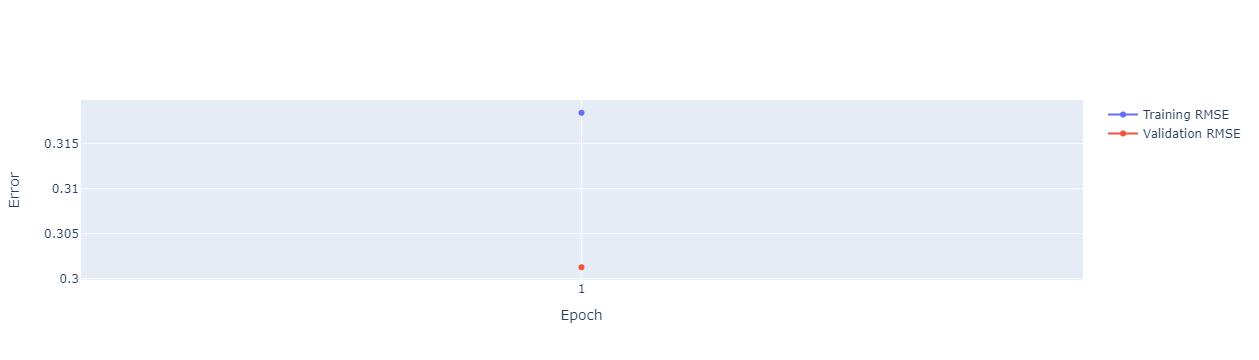

=== EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:34<00:00,  4.37it/s]


Saving the model at model1.pt...
Train RMSE: 0.3013166715050468
Validation results: {'RMSE': 0.30018966067224695, 'F1 score': 0.7559226113397216, 'Accuracy': 0.7431658662726265, 'Decision threshold': 0.6699999999999997}


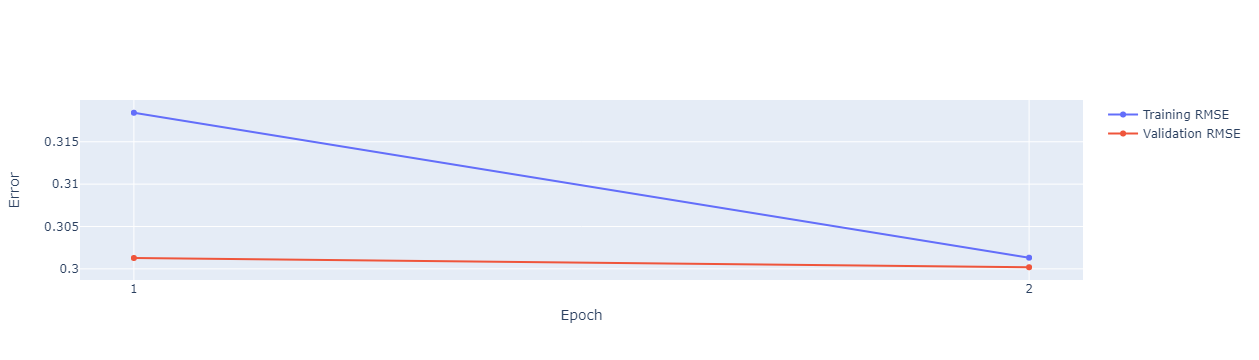

=== EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [03:08<00:00,  3.59it/s]


Saving the model at model1.pt...
Train RMSE: 0.299518943417861
Validation results: {'RMSE': 0.29889513139490537, 'F1 score': 0.7563768874758448, 'Accuracy': 0.717584041374215, 'Decision threshold': 0.6199999999999998}


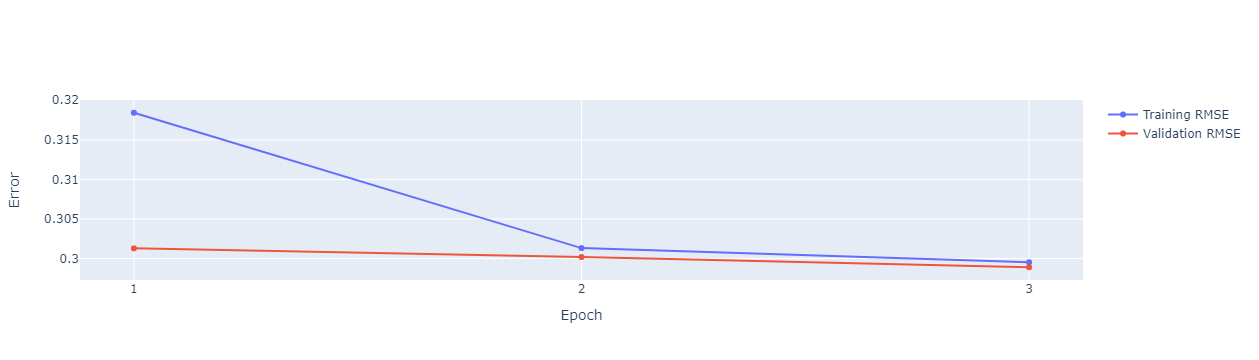

=== EPOCH 4


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [03:02<00:00,  3.72it/s]


Saving the model at model1.pt...
Train RMSE: 0.29737981020621235
Validation results: {'RMSE': 0.29816159698424344, 'F1 score': 0.75839614217903, 'Accuracy': 0.735962319911341, 'Decision threshold': 0.6199999999999998}


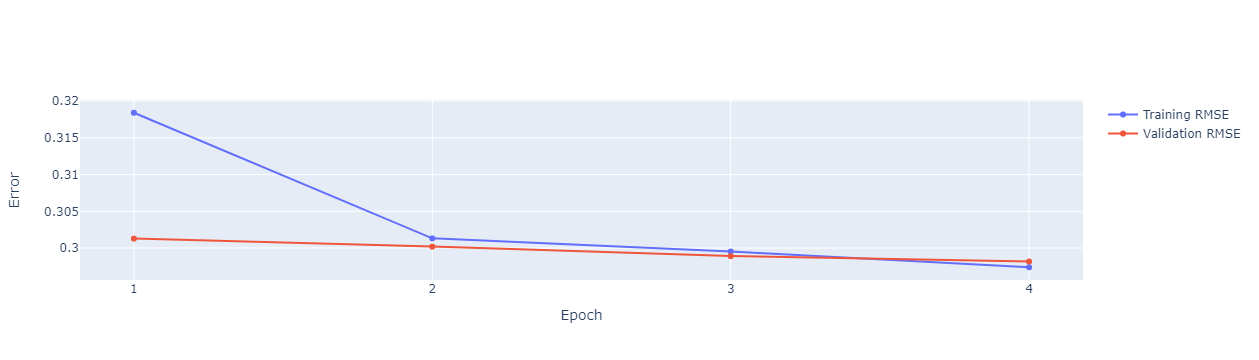

=== EPOCH 5


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [04:41<00:00,  2.41it/s]


Saving the model at model1.pt...
Train RMSE: 0.294328851563412
Validation results: {'RMSE': 0.29694525614116707, 'F1 score': 0.759503304965861, 'Accuracy': 0.6730698189878094, 'Decision threshold': 0.6099999999999998}


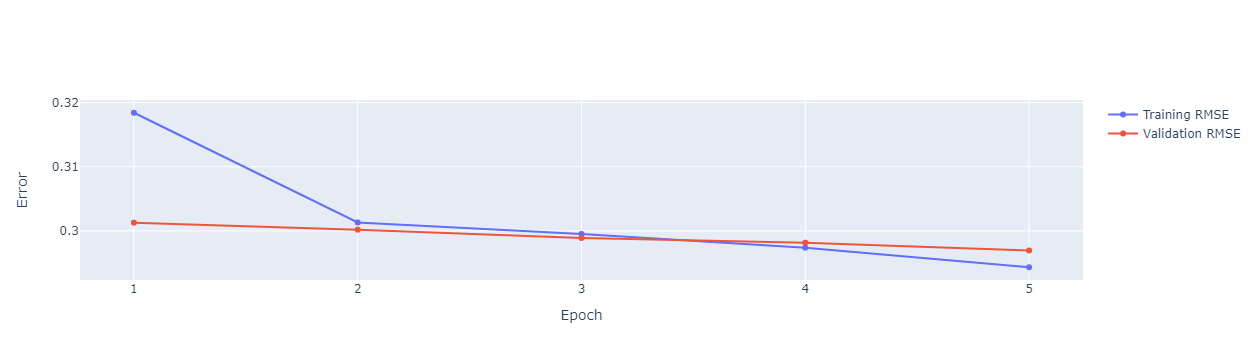

=== EPOCH 6


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [04:41<00:00,  2.41it/s]


Train RMSE: 0.28892476499156133
Validation results: {'RMSE': 0.2958769697580415, 'F1 score': 0.7551731518047002, 'Accuracy': 0.7125969708164019, 'Decision threshold': 0.6299999999999997}


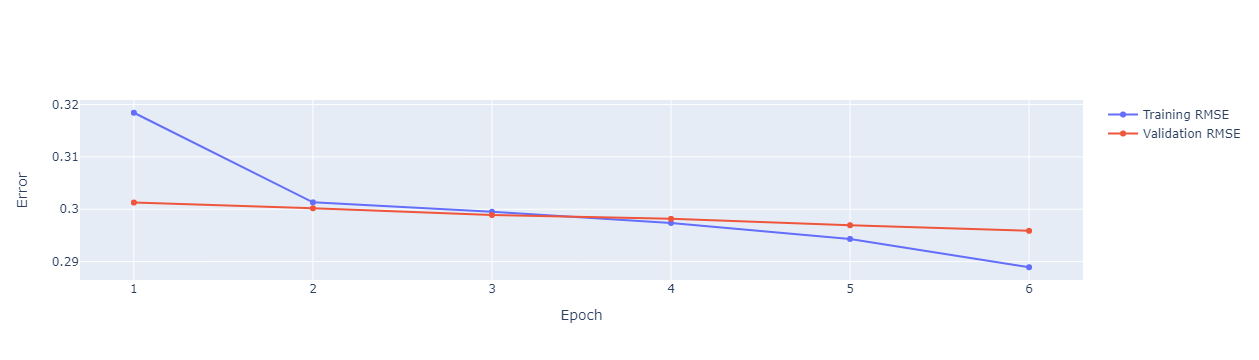

=== EPOCH 7


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [03:33<00:00,  3.18it/s]


Train RMSE: 0.28428353765409237
Validation results: {'RMSE': 0.3078792788737634, 'F1 score': 0.7559690050243225, 'Accuracy': 0.8061507203546361, 'Decision threshold': 0.6499999999999997}


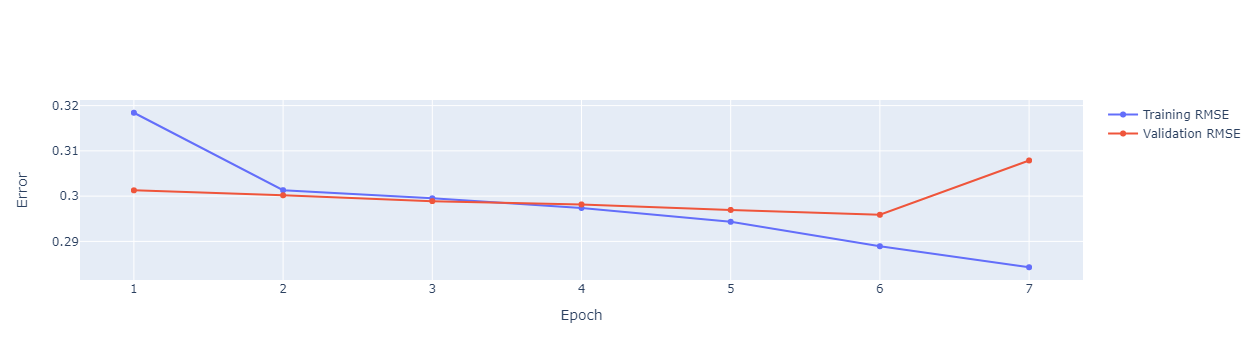

=== EPOCH 8


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [03:31<00:00,  3.21it/s]


Train RMSE: 0.2787721357607566
Validation results: {'RMSE': 0.2980368065825241, 'F1 score': 0.7566925356379239, 'Accuracy': 0.6779645363871445, 'Decision threshold': 0.5699999999999997}


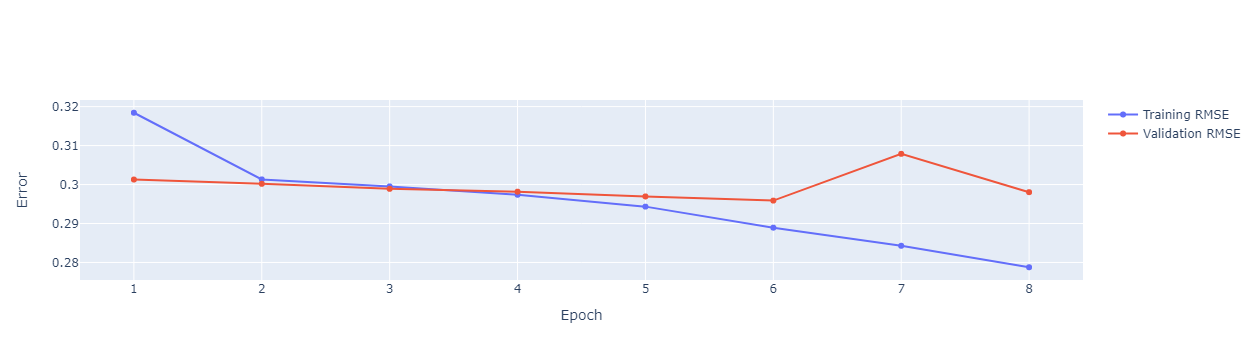

=== EPOCH 9


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [03:30<00:00,  3.22it/s]


Train RMSE: 0.27412023193646023
Validation results: {'RMSE': 0.29881577689525296, 'F1 score': 0.7562144565392973, 'Accuracy': 0.7717953454008127, 'Decision threshold': 0.7099999999999996}


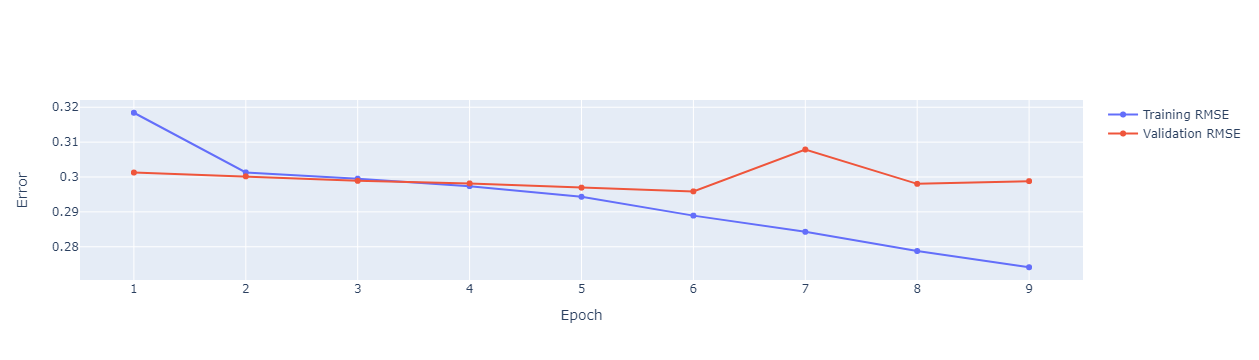

=== EPOCH 10


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [03:30<00:00,  3.22it/s]


Train RMSE: 0.27064756287515973
Validation results: {'RMSE': 0.30419302591985226, 'F1 score': 0.7530294759946468, 'Accuracy': 0.7650535648319172, 'Decision threshold': 0.6899999999999997}


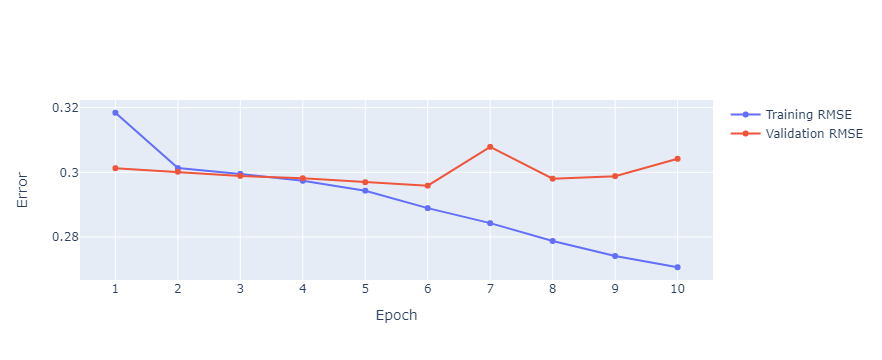

In [37]:
model_name = "model1.pt"

model = PassOutcomeModel(hidden_layer_size=128, dropout_rate=0.1)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0008753100506957126)

batch_size = 16

train_dataloader = torch.utils.data.DataLoader(PassesDataset(dataset=train_dataset, position_tensors_folder=position_tensors_folder), batch_size=batch_size, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(PassesDataset(dataset=validation_dataset, position_tensors_folder=position_tensors_folder), batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(PassesDataset(dataset=test_dataset, position_tensors_folder=position_tensors_folder), batch_size=batch_size, shuffle=True)

train(model, optimizer, train_dataloader, validation_dataloader, device, epochs=10, 
      save_model=True, model_name=model_name, save_graph=True, graph_name="train_val_losses1.png")

## Testing

We can now revert the model to its best version, obtain the decision threshold from the validation dataset, and evaluate the model with the test dataset and this decision threshold. I actually trained two versions, one with discretized angles that are 15 degrees apart and one with discretized angles that are 2 degrees apart. Odd decision threshold values are the artifacts from using `np.arange`.

### 15-degree angle groups (24 directions)

In [59]:
model_file = "model1_24.pt"

if os.path.isfile(model_file): # Obtaining the best version of the model
    model = torch.load(model_file)

model.to(device).eval()

validation_results = evaluate(model, validation_dataloader, device, decision_threshold="auto")
print("Validation:", validation_results)

test_results = evaluate(model, test_dataloader, device, decision_threshold=validation_results["Decision threshold"])
print("Test:", validation_results)

100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [04:07<00:00,  2.74it/s]


Validation: {'RMSE': 0.2969942544772671, 'F1 score': 0.759503304965861, 'Accuracy': 0.6730698189878094, 'Decision threshold': 0.6099999999999998}


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:26<00:00,  4.61it/s]

Test: {'RMSE': 0.2969942544772671, 'F1 score': 0.759503304965861, 'Accuracy': 0.6730698189878094, 'Decision threshold': 0.6099999999999998}


### 2-degree angle groups (180 directions)

In [60]:
model_file = "model1_180.pt"

if os.path.isfile(model_file): # Obtaining the best version of the model
    model = torch.load(model_file)

model.to(device).eval()

validation_results = evaluate(model, validation_dataloader, device, decision_threshold="auto")
print("Validation:", validation_results)

test_results = evaluate(model, test_dataloader, device, decision_threshold=validation_results["Decision threshold"])
print("Test:", validation_results)

100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:35<00:00,  4.35it/s]


Validation: {'RMSE': 0.29733176831502683, 'F1 score': 0.7583764705064648, 'Accuracy': 0.7704100480236424, 'Decision threshold': 0.6599999999999997}


100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:39<00:00,  4.25it/s]

Test: {'RMSE': 0.29733176831502683, 'F1 score': 0.7583764705064648, 'Accuracy': 0.7704100480236424, 'Decision threshold': 0.6599999999999997}


It is seen that the model performs much better than the baseline:

In [58]:
baseline = baseline_score(train_dataset, test_dataset)
print("Baseline (naive) model result:", baseline)

Baseline (naive) model result: {'F1 score': 0.45593407697718824, 'Accuracy': 0.838012560029553}


In [56]:
test_dataset2 = test_dataset.copy()
test_dataset2.cutback = 0

test_dataloader2 = torch.utils.data.DataLoader(PassesDataset(dataset=test_dataset2, position_tensors_folder=position_tensors_folder), batch_size=batch_size, shuffle=True)
test_results2 = evaluate(model, test_dataloader2, device, decision_threshold=validation_results["Decision threshold"])
print("Test:", validation_results)

100%|████████████████████████████████████████████████████████████████████████████████| 677/677 [02:23<00:00,  4.72it/s]

Test: {'RMSE': 0.2961293444301564, 'F1 score': 0.7583764705064648, 'Accuracy': 0.7704100480236424, 'Decision threshold': 0.6599999999999997}
